In [1]:
import openslide
import glob
from PIL import Image
import pandas as pd
from functools import reduce
import operator
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

/usr/local/lib/python3.4/dist-packages/matplotlib-1.5.1+1797.g6bed1be-py3.4-linux-x86_64.egg/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


In [40]:
files = glob.glob("data/*.ndpi")
groundTruth = pd.read_csv("data/groundTruth.csv")
groundTruth.head()

CaseNo  HeR2 SCORE  \
0       1           0   
1       4           2   
2       6           2   
3       9           3   
4      11           3   

   PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY  
0                                                  0                           
1                                                 60                           
2                                                 40                           
3                                                 70                           
4                                                 90

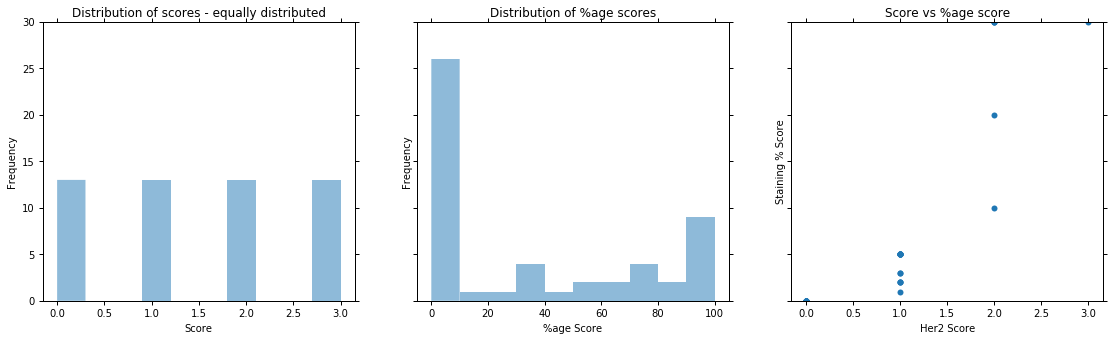

In [8]:
scores = groundTruth[["HeR2 SCORE"]].values
percentageScores = groundTruth[["PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY"]].values
f, ax = plt.subplots(1,3,sharey=True)
f.set_figheight(5)
f.set_figwidth(19)

ax[0].hist(scores,alpha=0.5)
ax[0].set_ylim([0,20])
ax[0].set_xlabel("Score")
ax[0].set_title("Distribution of scores - equally distributed")
ax[0].set_ylabel("Frequency")

ax[1].hist(percentageScores,alpha=0.5)
ax[1].set_ylim([0,30])
ax[1].set_xlabel("%age Score")
ax[1].set_title("Distribution of %age scores")
ax[1].set_ylabel("Frequency")

ax[2].scatter(scores,percentageScores)
ax[2].set_title("Score vs %age score")
ax[2].set_xlabel("Her2 Score")
ax[2].set_ylabel("Staining % Score")
plt.show()

In [41]:
data = []
areaCheck = []
for wsi in files:
    obs = openslide.open_slide(wsi)
    dims = obs.level_dimensions
    #Check to see that all dimensions within an image are downsampled by 4
    for i in range(len(dims))[:-1]:
        areai = reduce(operator.mul,dims[i])
        areai1 = reduce(operator.mul,dims[i+1])
        areaCheck.append(areai/float(areai1))
    nPixels = reduce(operator.mul,obs.dimensions)
    data.append({"dimension":obs.dimensions,"nPix":nPixels,"levelCount":obs.level_count})
print("All areas subsequently 4 times smaller than the previous level? ",np.all((np.array(areaCheck)==4)==True))
df = pd.DataFrame(data)
df.head()

All areas subsequently 4 times smaller than the previous level?  True


dimension  levelCount        nPix
0  (163840, 55296)          12  9059696640
1   (40960, 47872)           9  1960837120
2   (77824, 49152)          12  3825205248
3  (143360, 59392)          12  8514437120
4   (57344, 56064)           9  3214934016

In [42]:
def getRegion(caseNo,level,her):
    if her == 1:
        ext = "_HER2"
    else:
        ext = "_HE"
    obs = openslide.open_slide('data/'+str(caseNo)+ext+'.ndpi')
    dims = obs.level_dimensions[level]
    #print("Level dimensions ", dims)
    region = obs.read_region((0,0),level,(dims[0],dims[1]))
    return region

def stainScore(caseNo):
    case = groundTruth.loc[groundTruth.CaseNo==caseNo]
    score, percScore = case["HeR2 SCORE"].values[0], case["PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY"].values[0]
    return score, percScore

In [43]:
groundTruth.sort_values("PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY",inplace=1)

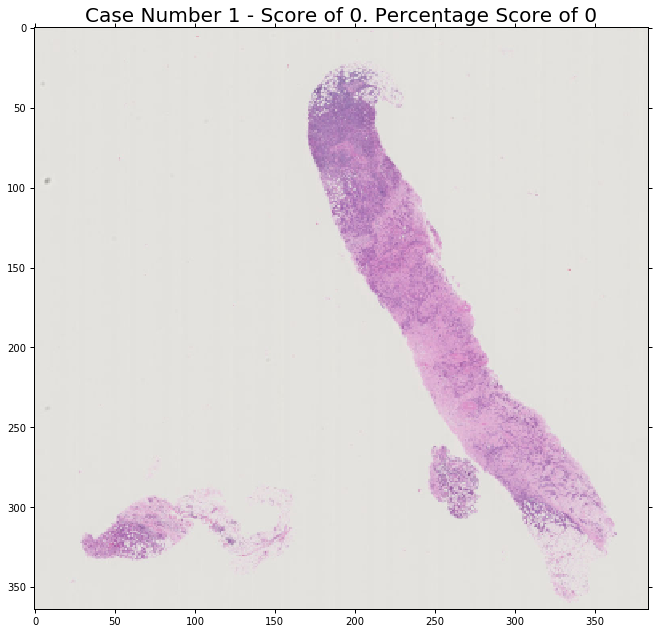

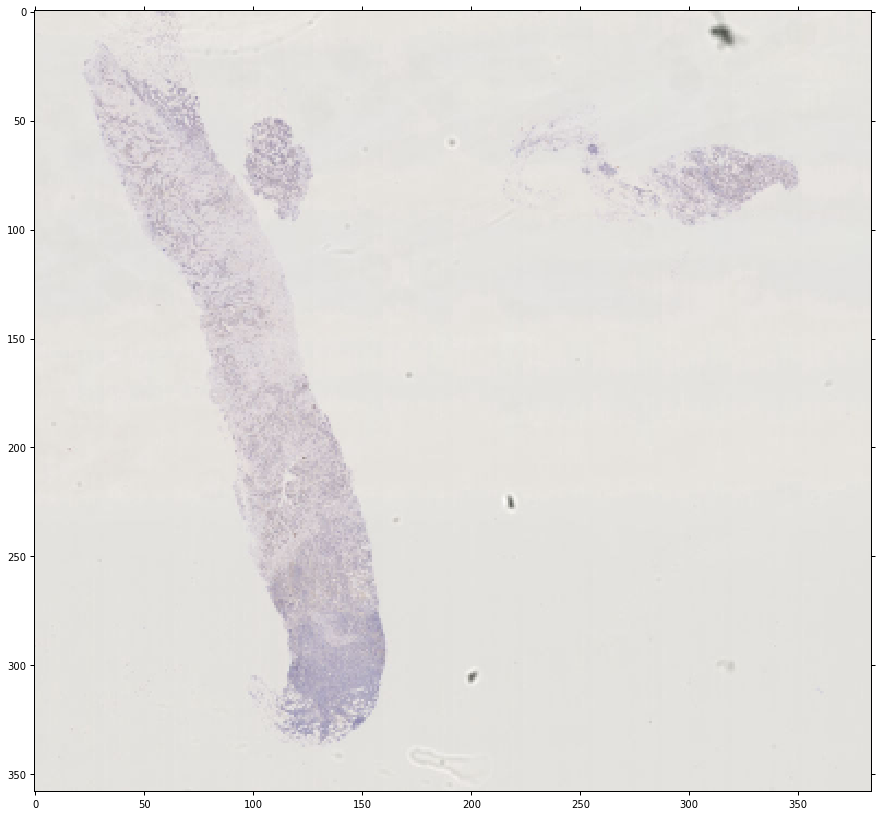

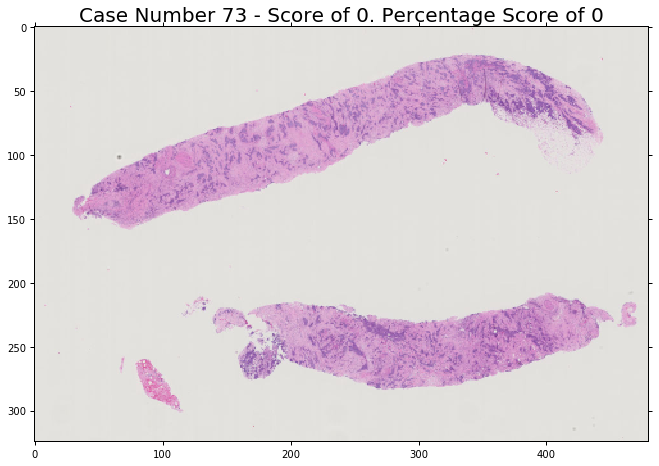

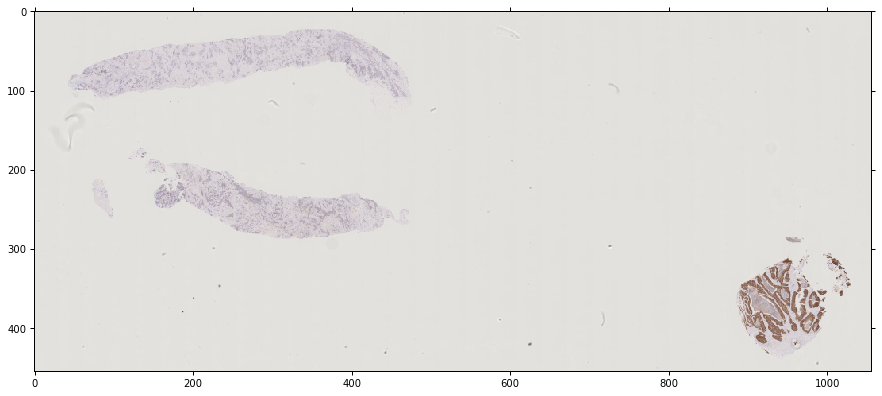

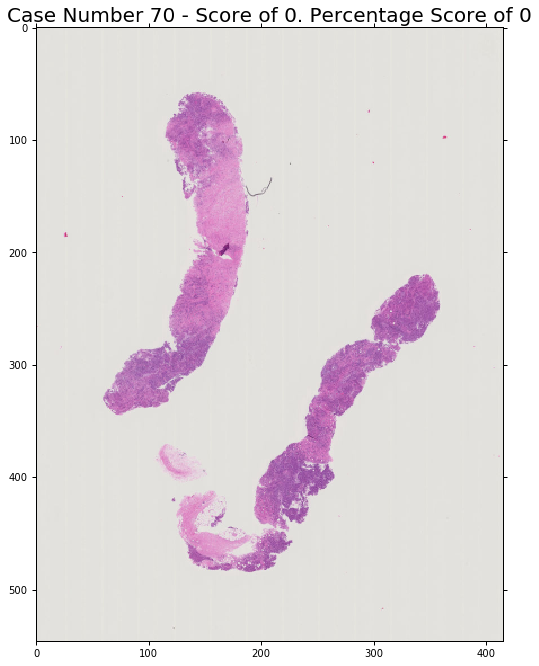

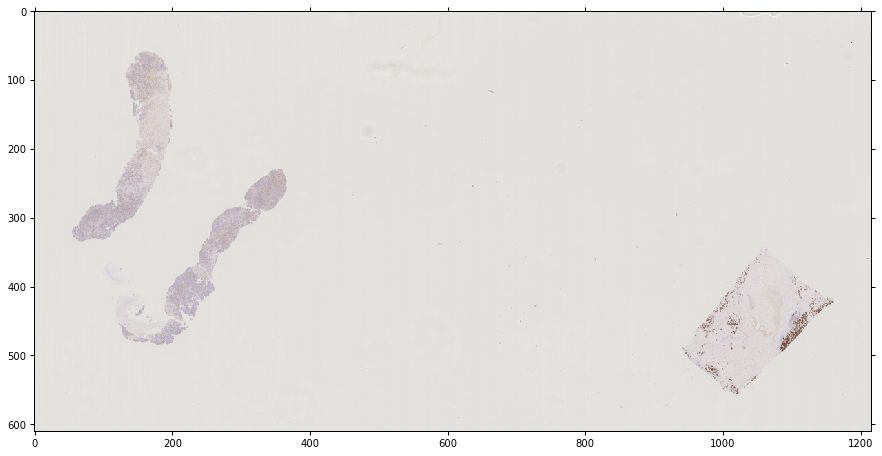

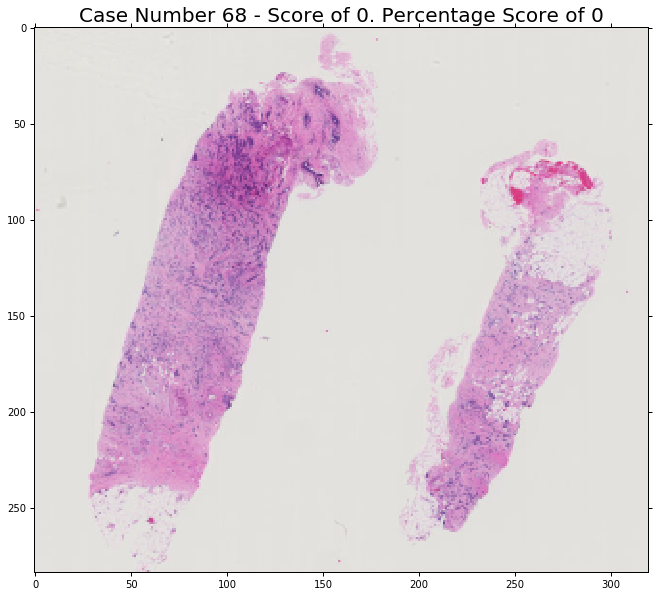

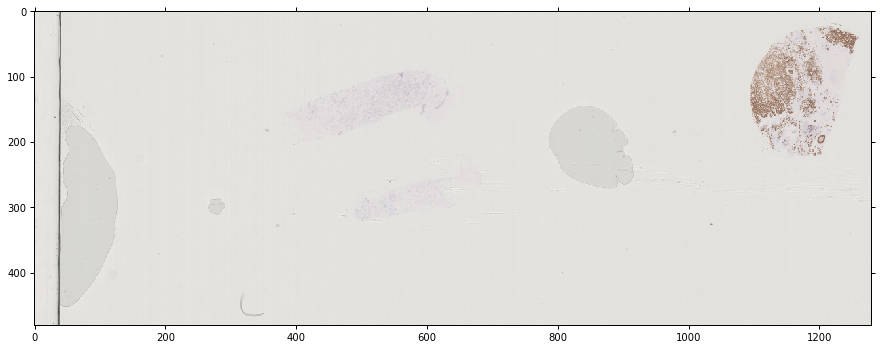

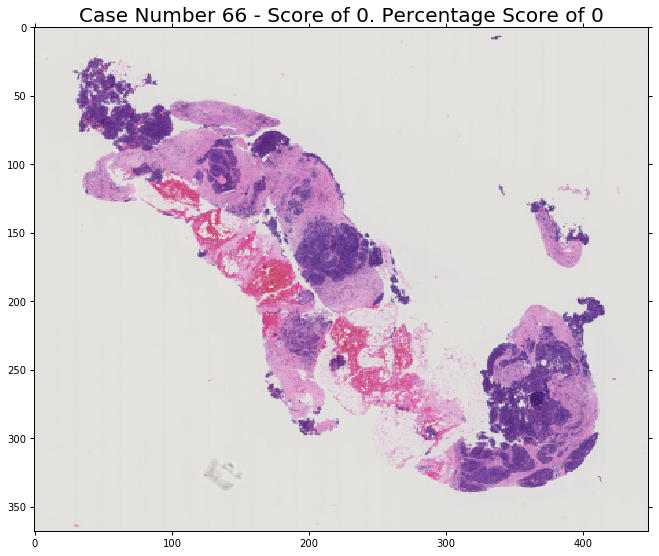

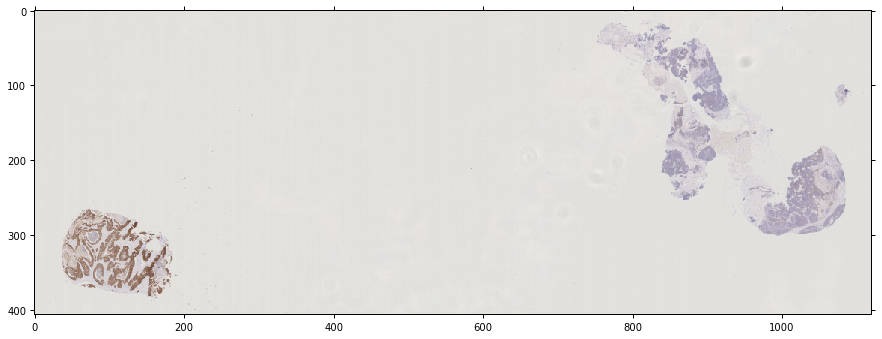

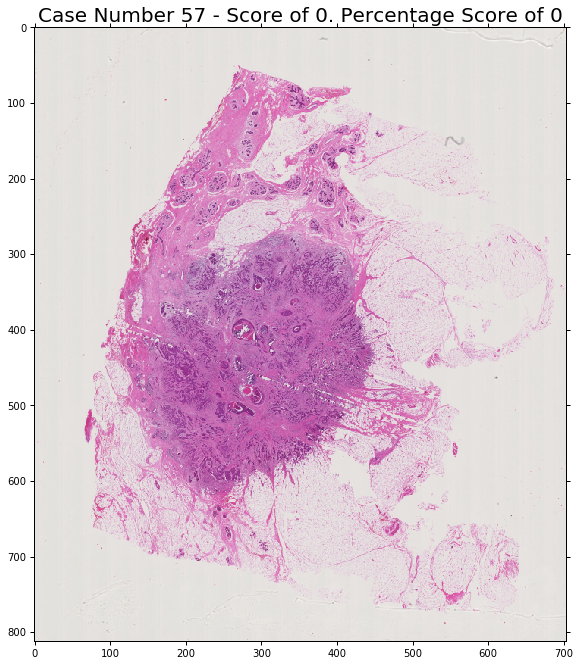

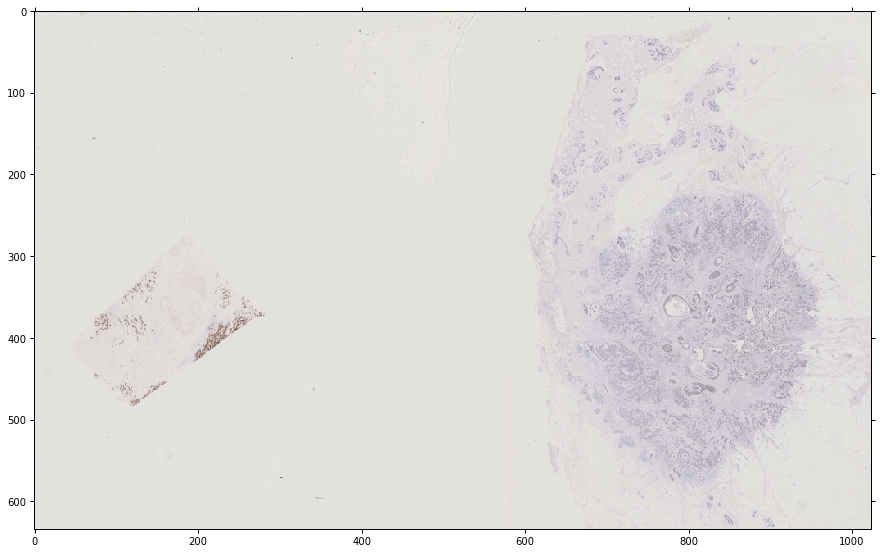

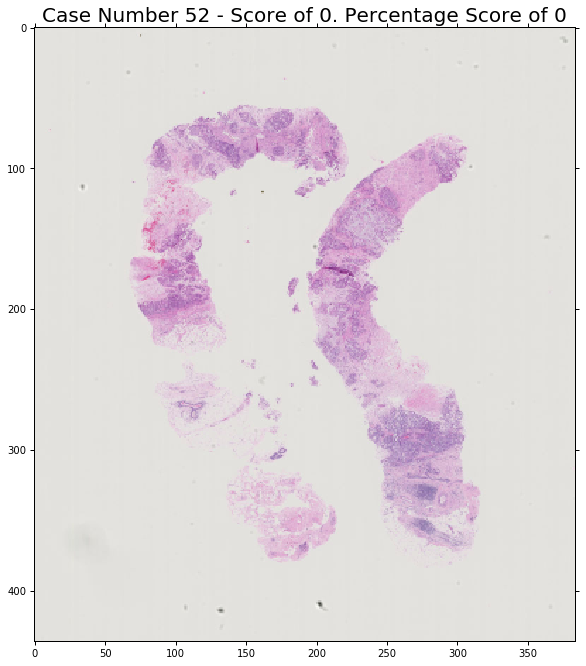

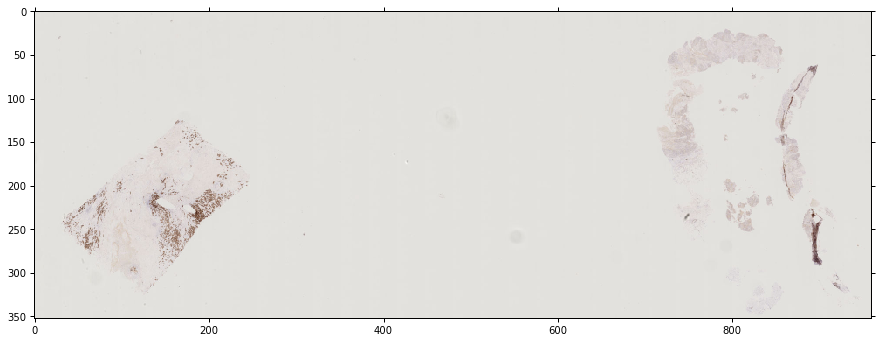

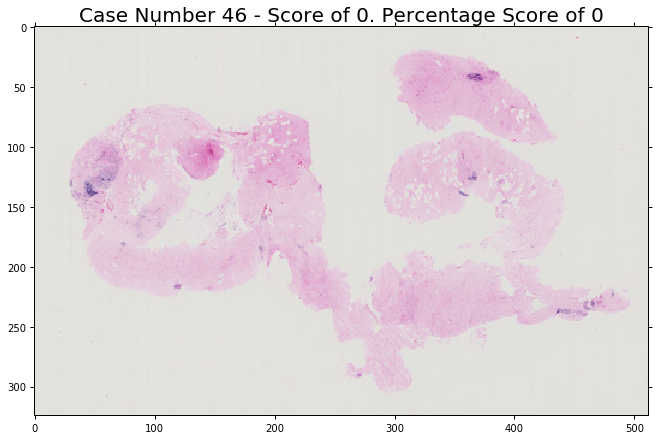

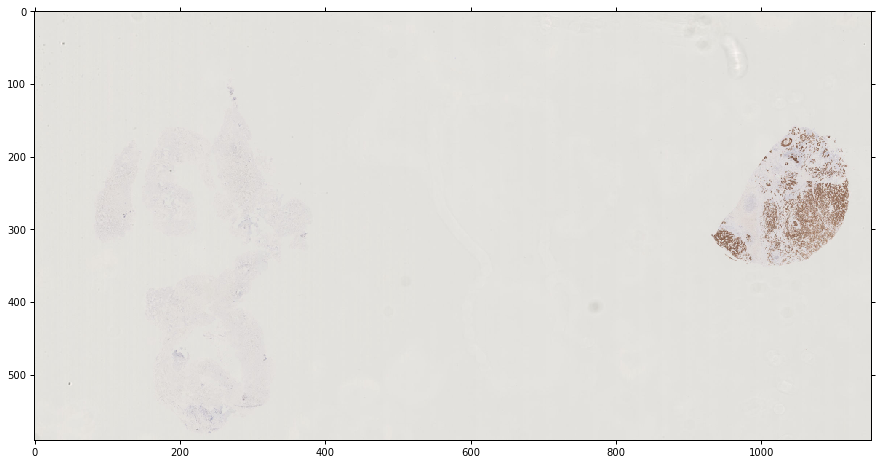

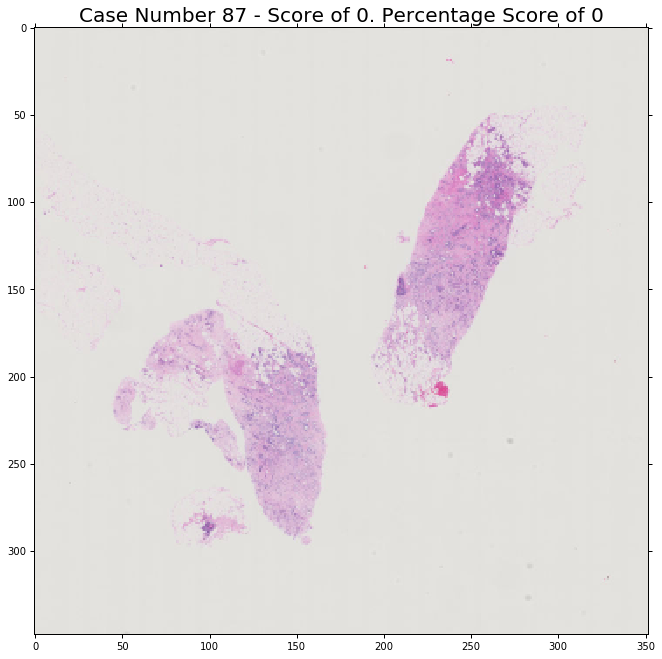

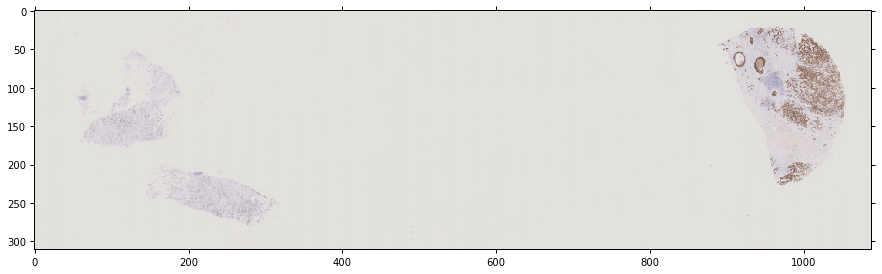

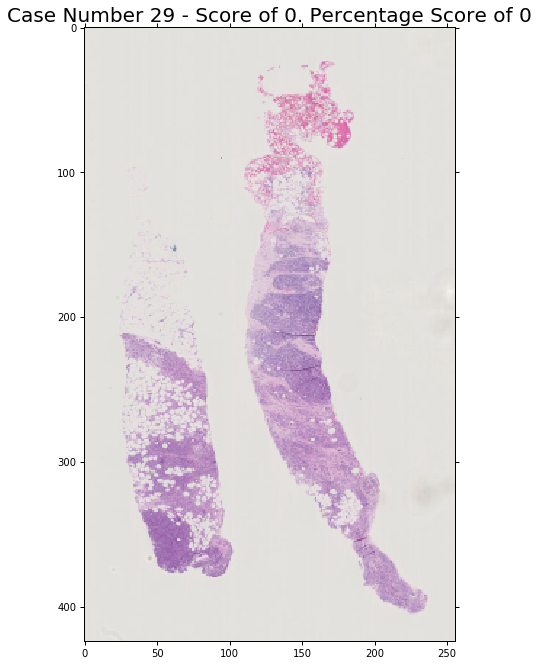

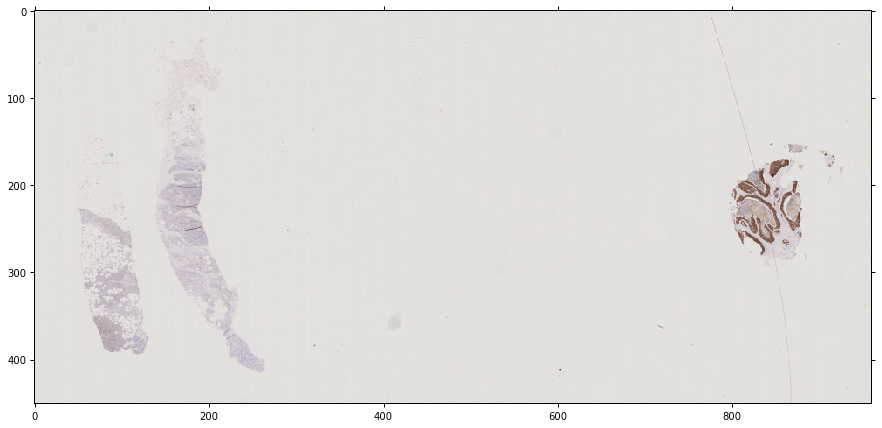

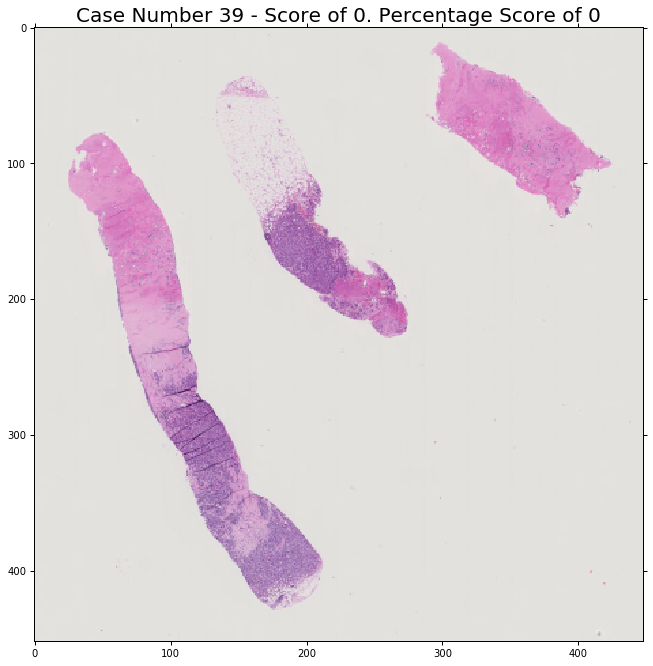

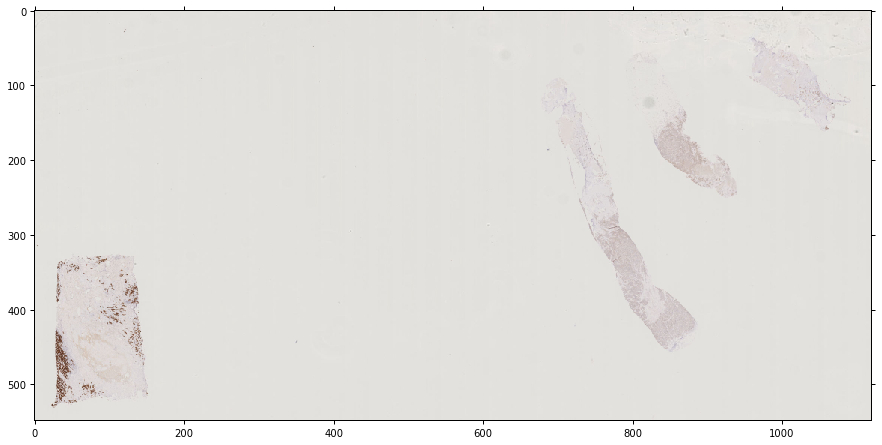

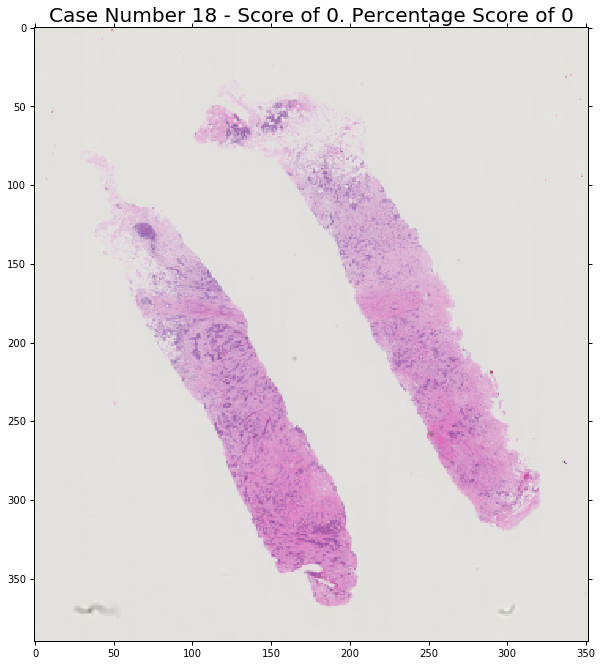

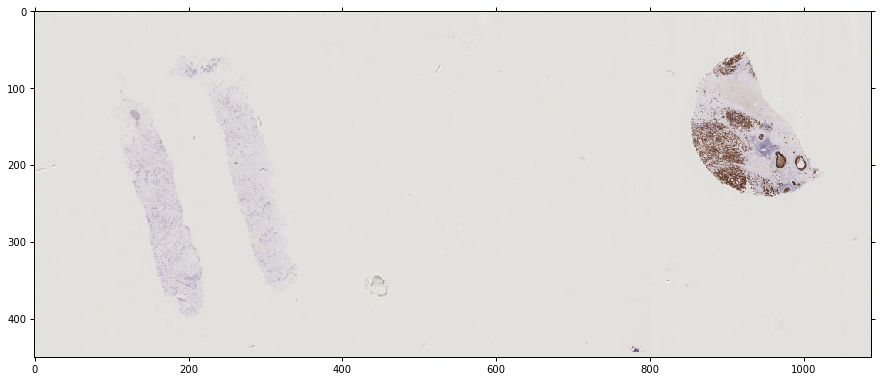

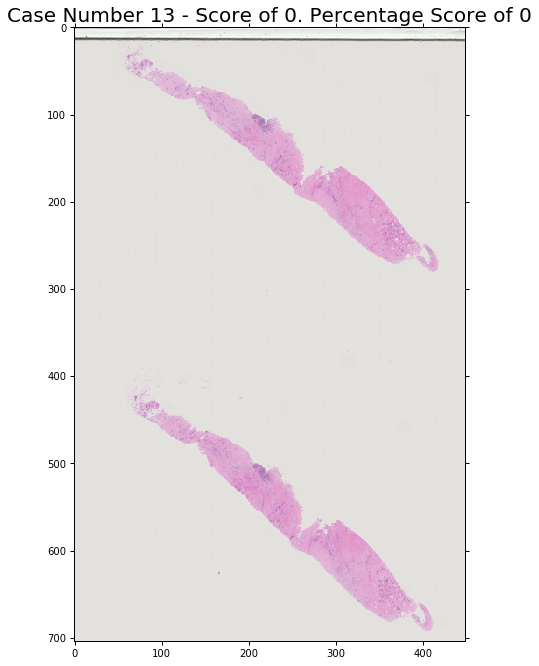

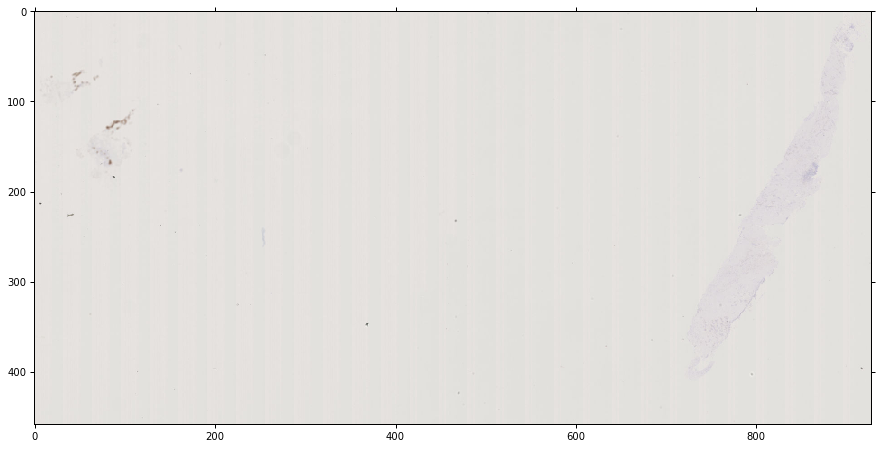

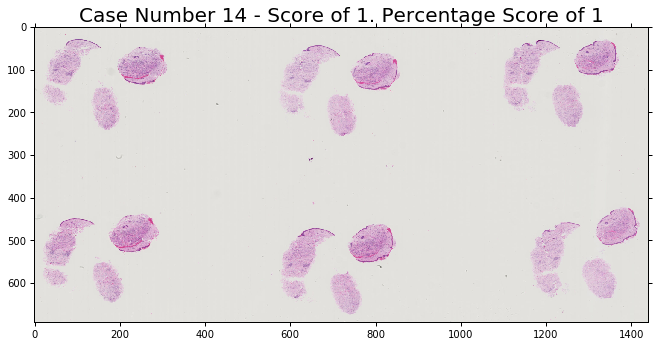

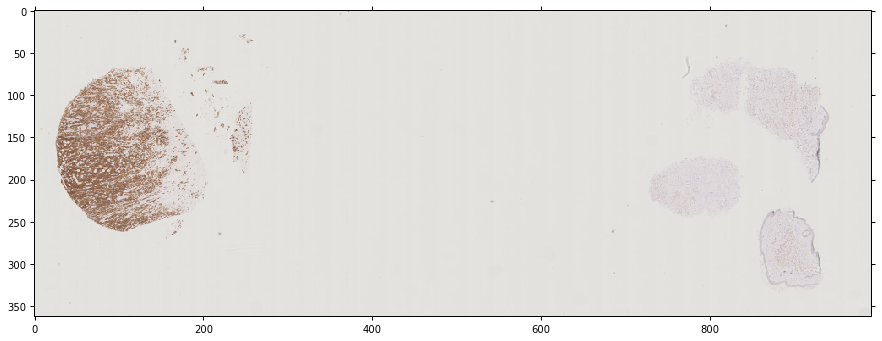

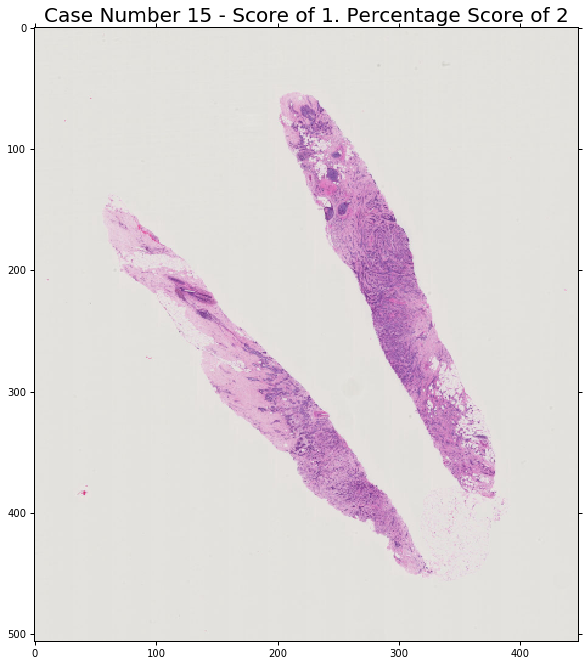

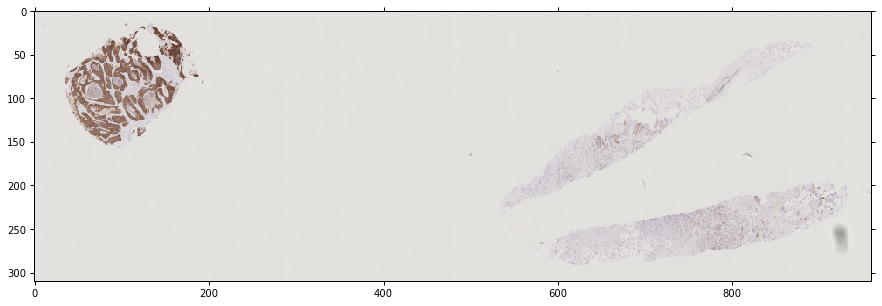

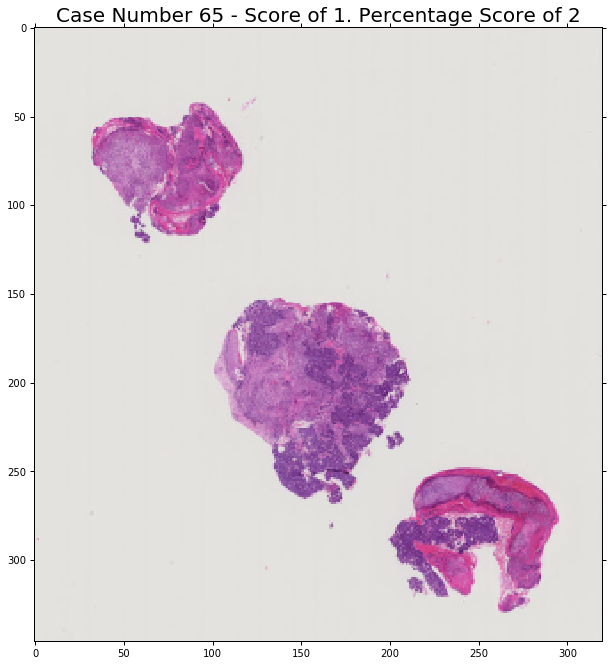

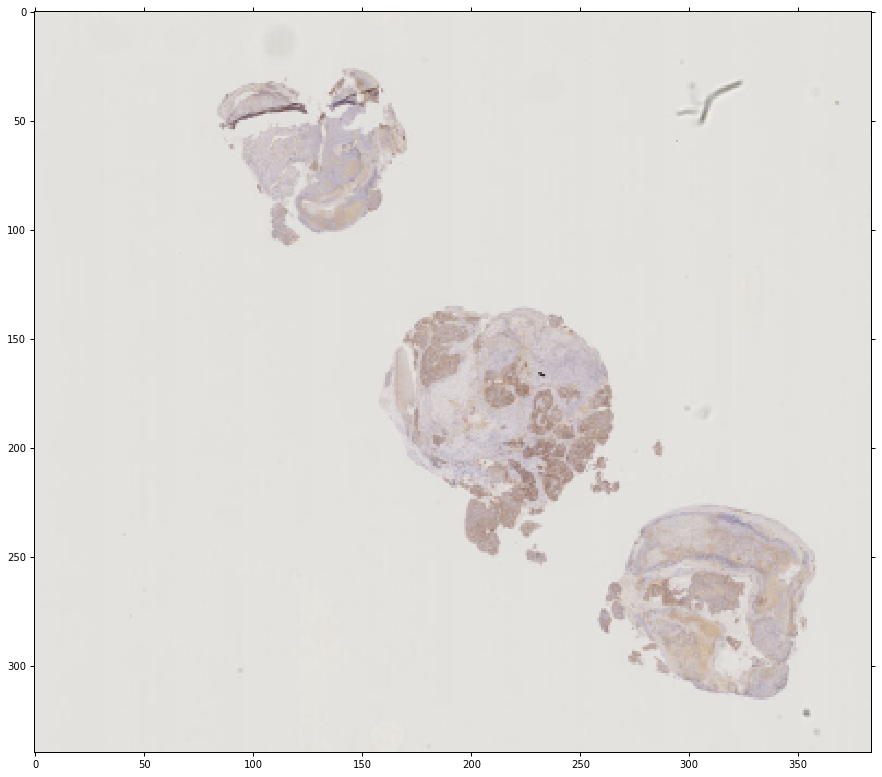

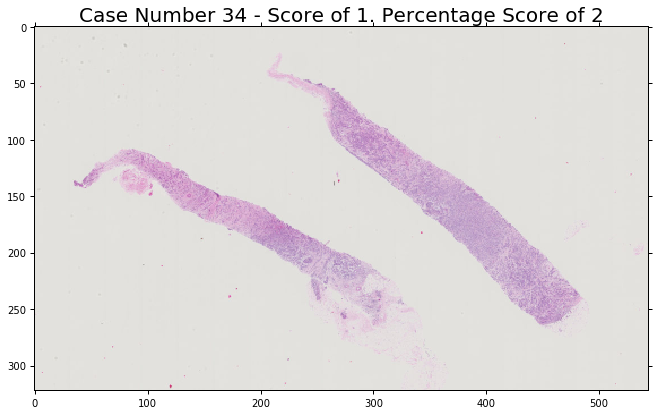

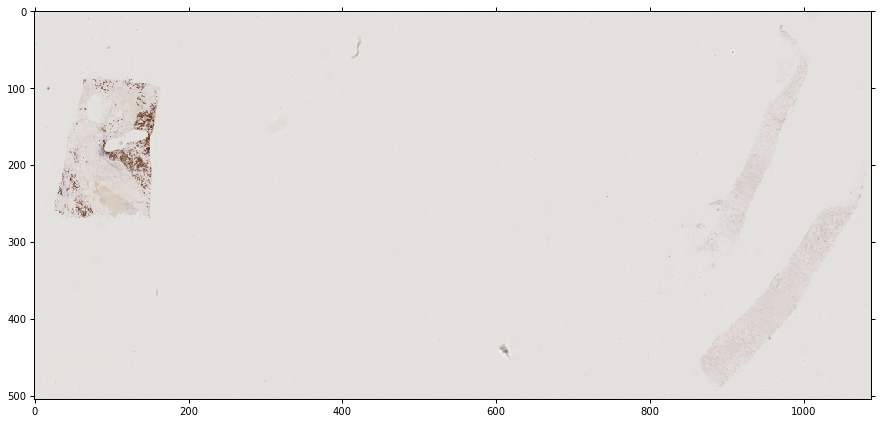

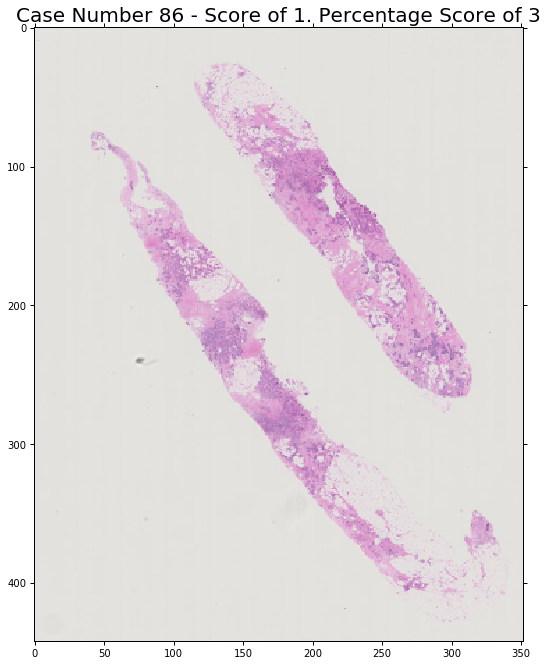

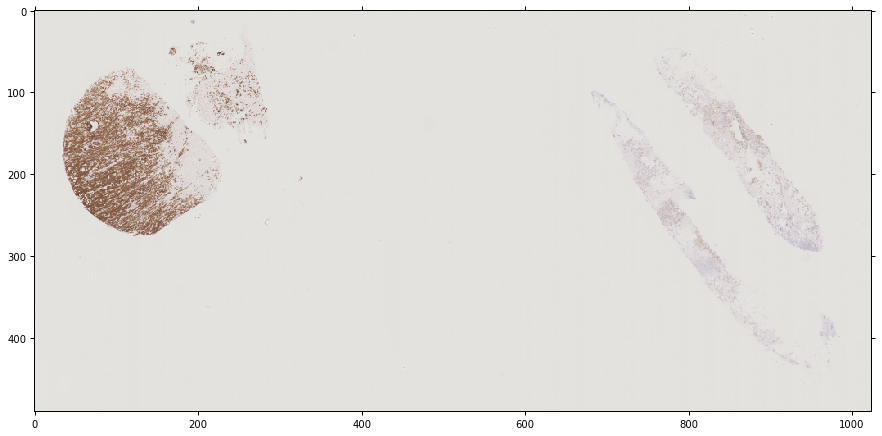

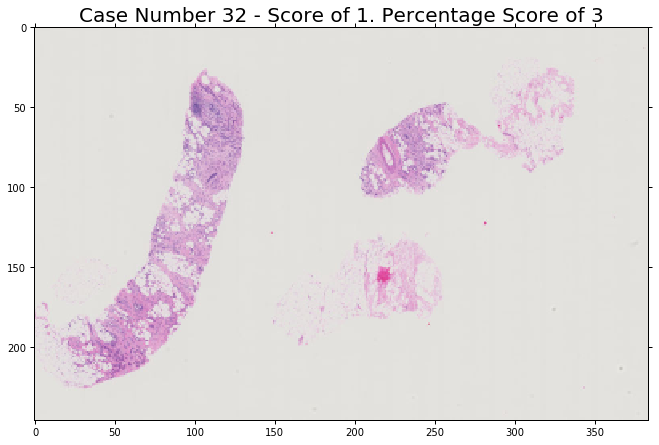

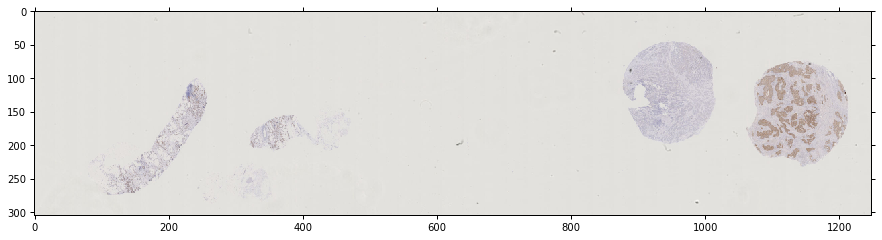

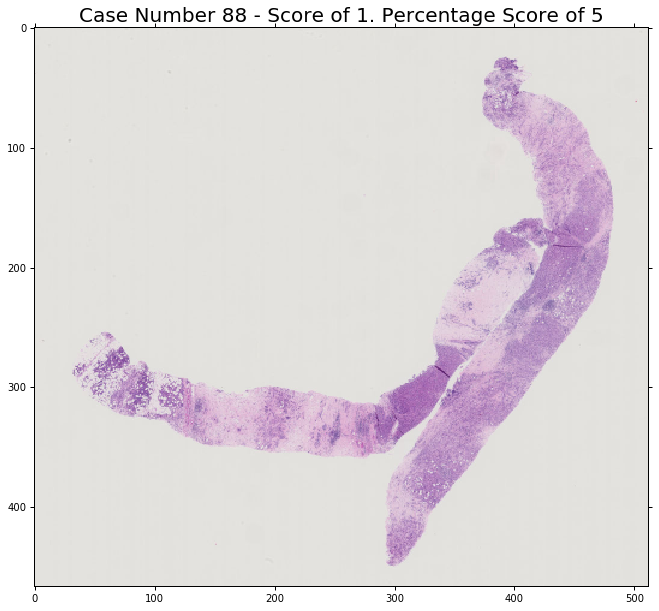

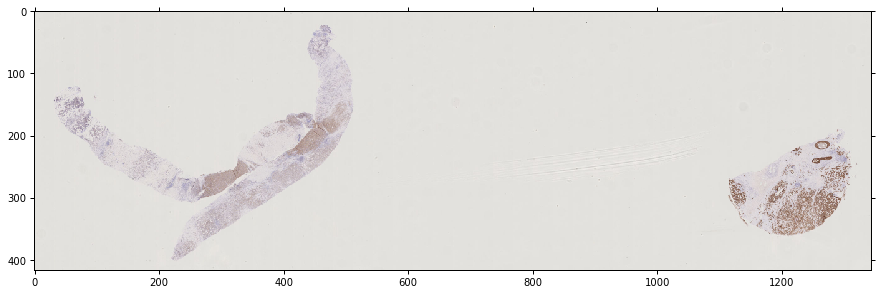

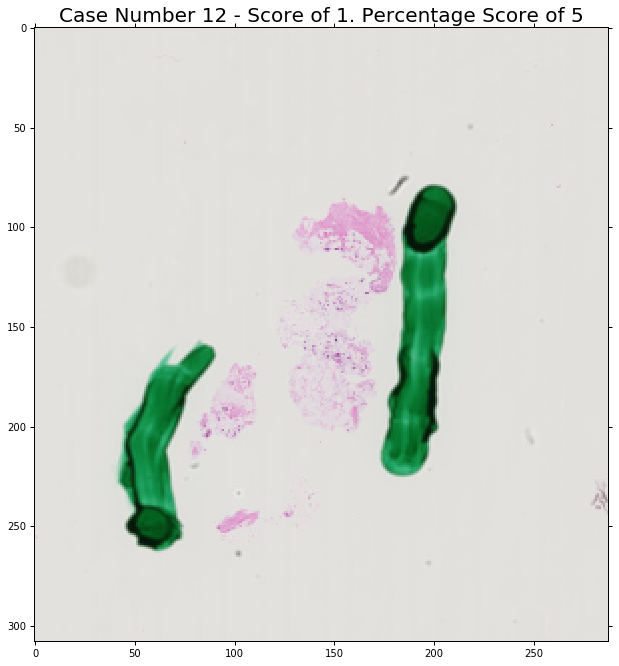

In [ ]:
level = 7
filesNotFound = []
for i in range(groundTruth.shape[0])[:]:
    caseNo = groundTruth.iloc[i].CaseNo
    try: 
        plt.figure(figsize=(11,11))
        score,percScore = stainScore(caseNo)
        plt.title("Case Number %d - Score of %d. Percentage Score of %d" % (caseNo,score,percScore), fontsize=20)
        plt.imshow(getRegion(caseNo,level,0))
        plt.show()
        plt.figure(figsize=(15,15))
        plt.imshow(getRegion(caseNo,level,1))
        plt.show()
        
    except FileNotFoundError:
        "Do not have file for case number %d" % caseNo
        filesNotFound.append(caseNo)
print("Files not found ", filesNotFound)       